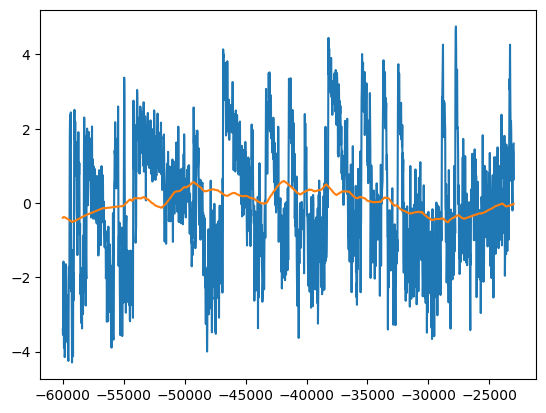

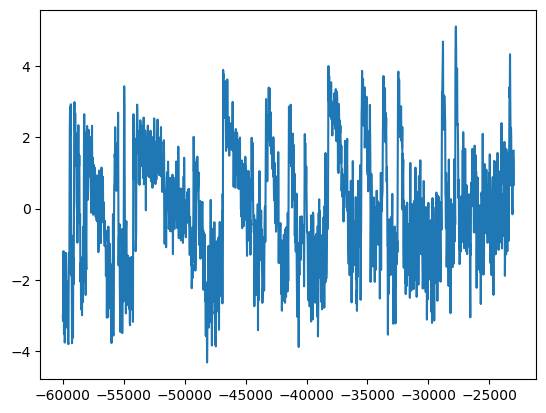

In [8]:
# load the data using pickle

import pickle

with open("D:/VScode/bipolar_seesaw_CCM/ice_core_data/interpolated_data.pkl", "rb") as f:
    data = pickle.load(f)

time = data["time"]
d18O_ant = data["d18O_ant"]
d18O_ngrip = data["d18O_ngrip"]

new_time_axis = time
detrended_d18O_ant = d18O_ant
detrended_d18O_ngrip = d18O_ngrip


with open("D:/VScode/bipolar_seesaw_CCM/inso_data/interpolated_data.pkl", "rb") as f:
    data = pickle.load(f)

pre = data["pre"]
obl = data["obl"]


# apply moving average smoothing for ngrip data with n=500
import numpy as np

n = 500
smoothed_d18O_ngrip = np.convolve(d18O_ngrip, np.ones(n)/n, mode="same")

# plot the unsmoothed and smoothed data
import matplotlib.pyplot as plt

plt.figure()
plt.plot(time, d18O_ngrip, label="unsmoothed")
plt.plot(time, smoothed_d18O_ngrip, label="smoothed")


# calculate the residuals of the detrended data
residuals =  detrended_d18O_ngrip-smoothed_d18O_ngrip

# plot the residuals
plt.figure()
plt.plot(time, residuals)

detrended_d18O_ngrip = residuals

# Find proper E and tau

In [9]:
import pandas as pd
import numpy as np

df_ant_edm = pd.DataFrame({
    'Time': new_time_axis,          # your time index (length 1851)
    'd18O': detrended_d18O_ant      # your detrended data
})

df_ngrip_edm = pd.DataFrame({
    'Time': new_time_axis,
    'd18O': detrended_d18O_ngrip
})


import pyEDM
import matplotlib.pyplot as plt

def find_best_E(df, E_values, data_column='d18O', 
                lib=None, pred=None, tau=-1, Tp=1, noTime=False):
    """
    df          : DataFrame with columns [Time, data_column]
    E_values    : iterable of embedding dimensions to test
    data_column : name of the column to forecast
    lib         : string specifying the library rows, e.g. '1 900'
    pred        : string specifying the prediction rows, e.g. '901 1851'
    tau         : embedding time-lag (default -1 = let pyEDM guess or use default)
    Tp          : prediction horizon (default 1)
    noTime      : if True, pyEDM will assume there's no separate time column
    """
    N = len(df)
    if lib is None or pred is None:
        # Example: first half for library, second half for prediction
        mid = N // 2
        lib  = f"1 {mid}"
        pred = f"{mid+1} {N}"
    
    results = {}
    for E in E_values:
        # Run Simplex
        simplex_out = pyEDM.Simplex(
            dataFrame = df,
            columns   = data_column,  # library columns
            target    = data_column,  # predict the same variable
            lib       = lib,
            pred      = pred,
            E         = E,
            Tp        = Tp,
            tau       = tau,
            knn       = 0,        # 0 => use E+1 neighbors
            embedded  = False,    # let pyEDM embed for us
            noTime    = noTime,   # if the first column is Time, set noTime=False
            showPlot  = False
        )
        
        # simplex_out is a DataFrame with columns ["Time","Observations","Predictions"]
        obs = simplex_out["Observations"].values
        pred_ = simplex_out["Predictions"].values
        
        # Compute correlation, ignoring NaNs
        valid_idx = ~np.isnan(obs) & ~np.isnan(pred_)
        if np.sum(valid_idx) > 1:
            rho_val = np.corrcoef(obs[valid_idx], pred_[valid_idx])[0,1]
        else:
            rho_val = np.nan
        
        results[E] = rho_val
    
    return results


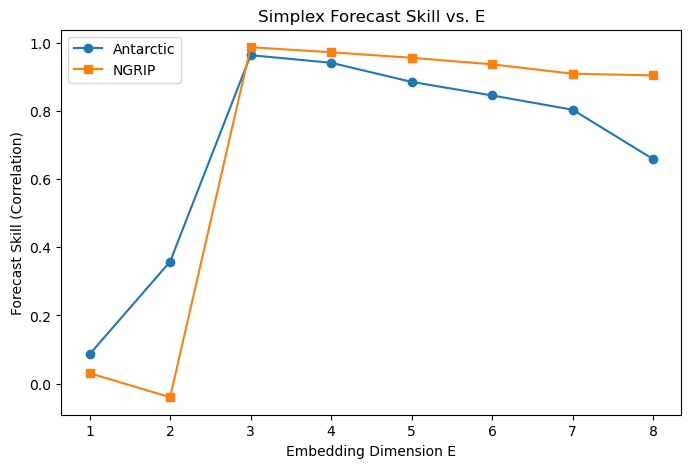

In [10]:
# Range of E to test
E_candidates = range(1, 9)  # 1..8

# Antarctic
ant_results = find_best_E(
    df_ant_edm, 
    E_values = E_candidates, 
    data_column = 'd18O',
    tau = 50,           # Example: use time-lag of 1
    Tp = 50,           # 1-step-ahead forecast
    lib='1 900',      # e.g. rows 1..900 as library
    pred='901 1851',  # rows 901..1851 as prediction
    noTime=False
)

# NGRIP
ngrip_results = find_best_E(
    df_ngrip_edm, 
    E_values = E_candidates, 
    data_column = 'd18O',
    tau = 50,
    Tp = 50,
    lib='1 900',
    pred='901 1851',
    noTime=False
)

# Convert dictionary to lists for plotting
E_vals = sorted(ant_results.keys())
ant_rho = [ant_results[E] for E in E_vals]
ngrip_rho = [ngrip_results[E] for E in E_vals]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(E_vals, ant_rho, marker='o', label='Antarctic')
plt.plot(E_vals, ngrip_rho, marker='s', label='NGRIP')
plt.xlabel('Embedding Dimension E')
plt.ylabel('Forecast Skill (Correlation)')
plt.title('Simplex Forecast Skill vs. E')
plt.legend()
plt.show()


In [12]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tau_values   = range(10, 101, 10)  # 10,20,30,...,100
E_candidates = range(1, 9)        # 1..8

# 2) We'll store results in 2D arrays:
#    rows = different tau, cols = different E
ant_results_3d   = np.zeros((len(tau_values), len(E_candidates)))
ngrip_results_3d = np.zeros((len(tau_values), len(E_candidates)))

# 3) Loop over all tau and E values to fill in the 2D arrays
for i, tau in enumerate(tau_values):
    ant_results = find_best_E(
        df_ant_edm, 
        E_values = E_candidates, 
        data_column = 'd18O',
        tau = tau,
        Tp = tau,           # forecast tau steps ahead
        lib='1 900',        # e.g. rows 1..900 as library
        pred='901 1851',    # rows 901..1851 as prediction
        noTime=False
    )
    ngrip_results = find_best_E(
        df_ngrip_edm, 
        E_values = E_candidates, 
        data_column = 'd18O',
        tau = tau,
        Tp = tau,
        lib='1 900',
        pred='901 1851',
        noTime=False
    )
    
    for j, E in enumerate(E_candidates):
        ant_results_3d[i,j]   = ant_results[E]
        ngrip_results_3d[i,j] = ngrip_results[E]

# e.g. to create mesh for x=E, y=tau:
E_grid, Tau_grid = np.meshgrid(E_candidates, tau_values)  # each shape: (len(tau_values), len(E_candidates))


# Create a 1x2 grid of 3D subplots
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["Antarctic", "NGRIP"]
)

# -- Add the Antarctic surface (left subplot, row=1,col=1)
fig.add_trace(
    go.Surface(
        x=E_grid,          # embedding dimension
        y=Tau_grid,        # tau
        z=ant_results_3d,  # correlation skill
        colorscale='Viridis',
        name='Antarctic'
    ),
    row=1, col=1
)

# -- Add the NGRIP surface (right subplot, row=1,col=2)
fig.add_trace(
    go.Surface(
        x=E_grid,
        y=Tau_grid,
        z=ngrip_results_3d,
        colorscale='Viridis',
        name='NGRIP'
    ),
    row=1, col=2
)

# Update layout for each subplot’s axes and overall figure
fig.update_layout(
    title="Forecast Skill vs. E and tau (Tp = tau)",
    width=1200, height=600
)

# Customize the axis titles on each 3D subplot
fig.update_scenes(
    dict(
        xaxis_title="E (Embedding Dimension)",
        yaxis_title="tau (Lag & Forecast Steps)",
        zaxis_title="Forecast Skill (rho)"
    ),  # scene1 settings
    row=1, col=1
)
fig.update_scenes(
    dict(
        xaxis_title="E (Embedding Dimension)",
        yaxis_title="tau (Lag & Forecast Steps)",
        zaxis_title="Forecast Skill (rho)"
    ),  # scene2 settings
    row=1, col=2
)

fig.show()


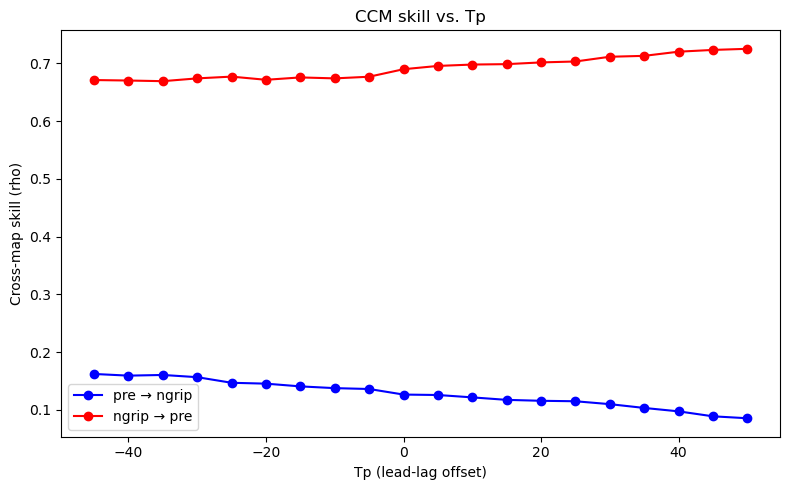

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM


N= len(new_time_axis)

df = pd.DataFrame({
    'Time': np.arange(N),
    'ngrip':    detrended_d18O_ngrip,
    'pre':    pre,
})

# ------------------------------------------------
# 2) Loop over Tp in steps of 2 from 0 to 30
# ------------------------------------------------
Tps = range(50, -50, -5)  # 0, 2, 4, ..., 30

XtoY_skills = []
YtoX_skills = []

for tp in Tps:
    # Run CCM once; PyEDM.CCM will report both X->Y and Y->X skill
    ccm_out = CCM(
        dataFrame   = df,
        E           = 3,                       # embedding dimension
        tau         = 5,                      # time delay (example)
        columns     = "ngrip",                     # 'X' is the manifold source
        target      = "pre",                     # 'Y' is the variable we predict
        libSizes    = "200 400 600",  # library sizes
        sample      = 200,
        random      = True,
        replacement = False,
        Tp          = tp                       # vary this offset
    )

    # Extract final row (largest library size) for cross-map skill
    # ccm_out typically has columns: ['LibSize','X:Y','Y:X',...]
    final_row = ccm_out.iloc[-1]
    x_to_y_skill = final_row['ngrip:pre']   # correlation for X->Y
    y_to_x_skill = final_row['pre:ngrip']   # correlation for Y->X

    XtoY_skills.append(x_to_y_skill)
    YtoX_skills.append(y_to_x_skill)

# ------------------------------------------------
# 3) Plot the results
# ------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(Tps, XtoY_skills, 'bo-', label='pre → ngrip')
plt.plot(Tps, YtoX_skills, 'ro-', label='ngrip → pre')
plt.xlabel("Tp (lead-lag offset)")
plt.ylabel("Cross-map skill (rho)")
plt.title("CCM skill vs. Tp")
plt.legend()
plt.tight_layout()
plt.show()


    LibSize       X:Y       Y:X
0     100.0  0.553578  0.071555
1     200.0  0.662259  0.088365
2     300.0  0.705899  0.090606
3     400.0  0.733309  0.087917
4     500.0  0.745306  0.096716
5     600.0  0.755078  0.099003
6     700.0  0.762495  0.100974
7     800.0  0.768551  0.105110
8     900.0  0.772928  0.104435
9    1000.0  0.777278  0.107526
10   1100.0  0.779777  0.107928
11   1200.0  0.782849  0.109742
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


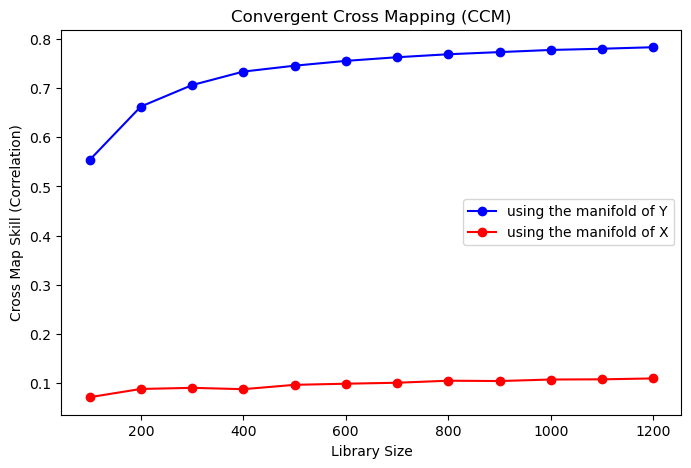

In [4]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt

# Prepare DataFrame
df = pd.DataFrame({
    'Time': new_time_axis,
    'X': pre,  
    'Y': detrended_d18O_ngrip     
})

# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 50,
    columns     = "X",   # predictor (ngrip)
    target      = "Y",   # target (pre)
    libSizes    = "100 200 300 400 500 600 700 800 900 1000 1100 1200",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 200,
    verbose     = True
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# Plot the results with custom legend labels
plt.figure(figsize=(8,5))
# For X:Y: predictor is ngrip, target is ant -> label: "ant^|Mngrip"
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='using the manifold of Y')
# For Y:X: predictor is ant, target is ngrip -> label: "ngrip^|Mant"
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='using the manifold of X')

plt.xlabel('Library Size')
plt.ylabel('Cross Map Skill (Correlation)')
plt.title('Convergent Cross Mapping (CCM)')
plt.legend(loc='best')
plt.show()


In [8]:
import numpy as np
from scipy.spatial import distance
from scipy.stats import pearsonr

class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):

        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold   
        

    def shadow_manifold(self, X):
        X = X[:self.L] # make sure we cut at L
        M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold, here t is the time-step index in the original time series
        for t in range((self.E-1) * self.tau, self.L):
            x_lag = [] # lagged values
            for t2 in range(0, self.E-1 + 1): # dimension E
                x_lag.append(X[t-t2*self.tau])               # in each te, calculate values at column 0, 1, E    
            M[t] = x_lag
        return M # the dimension of M should be L-(E-1)*tau by E, each row is a point in the shadow manifold
    


    def get_distances(self, Mx):
        t_vec = [(k, v) for k,v in Mx.items()] #  k is the key and v is the value from the dictionary Mx
        t_steps = np.array([i[0] for i in t_vec]) # the row index
        vecs = np.array([i[1] for i in t_vec]) # the coordinates of the points in the shadow manifold
        dists = distance.cdist(vecs, vecs)    # calculate pairwise distances 
        return t_steps, dists
    


    def get_nearest_distances(self, t, t_steps, dists):

        t_ind = np.where(t_steps == t) # get the index of time t, here the index is for the points in the manifold
        dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
        
        nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
        nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
        nearest_distances = dist_t[nearest_inds]  
        
        return nearest_timesteps, nearest_distances
    


    def predict(self, t):

        eps = 0.000001 # epsilon minimum distance possible
        t_ind = np.where(self.t_steps == t) # get the index of time t
        # dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
        nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
        
        # get weights
        u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
        w = u / np.sum(u)
        
        # get prediction of X
        X_true = self.X[t] # get corresponding true X
        X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
        X_hat = (w * X_cor).sum() # get X_hat
        
        return X_true, X_hat
    


    def causality(self):
       
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat) 

        x, y = X_true_list, X_hat_list
        r, p = pearsonr(x, y)        

        return r, p
    

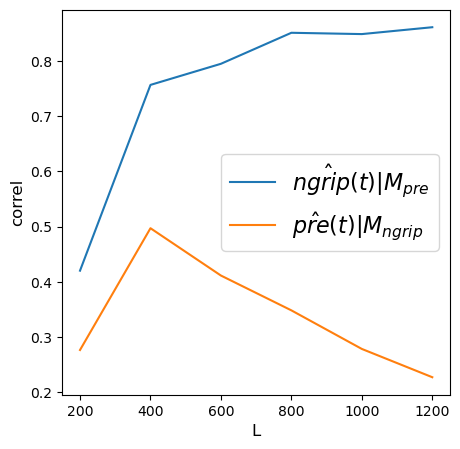

In [13]:
import matplotlib.pyplot as plt

X=detrended_d18O_ngrip
Y=pre

# Looking at "convergence"
L_range = range(200, 1400, 200) # L values to test
tau = 50
E = 3

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # from the manifold of Y Predict X #
    ccm_YX = ccm(Y, X, tau, E, L) # from the manifold of X Predict Y #
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{ngrip}(t)|M_{pre}$')
plt.plot(L_range, Yhat_Mx, label='$\hat{pre}(t)|M_{ngrip}$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})   